Build and visualize the parameterization dataframe with global participant related information and visualize 
(CONTINUES IN 'analysis_parameterization.ipynb')

In [1]:
## Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm
from matplotlib import pyplot as plt
import nibabel as nib
from scipy.signal import find_peaks

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
""" Load aligned to most neutral position sulcus"""
N_sulci = 606

path_name="/mnt/projects/VIA_Marlene/backup/BrainVisa/scripts/output/complete_dataset/paths_all_criteria_star.txt"
path_df = pd.read_csv(path_name, sep=',', header=None)
path = np.array(path_df)

In [3]:
# Clean different shapes and depth outliers

shape_all = []
idx_diff_shape = []
for i in range(N_sulci):
    # See source_binary
    path_cs = path[i] + '.nii.gz'
    tmp = nib.load(path_cs[0])
    cs = tmp.get_fdata()

    shape_all.append(np.shape(cs))

    if np.shape(cs) != tuple([288, 288, 192]):
        idx_diff_shape.append(i)

In [57]:
N_sulci = 606

path_name="/mnt/projects/VIA_Marlene/backup/BrainVisa/scripts/output/complete_dataset/paths_all_criteria_star.txt"
path_df = pd.read_csv(path_name, sep=',', header=None)
path = np.array(path_df)

data_param = np.empty((N_sulci, 101, 3))
data_medial_ax = np.empty((N_sulci, 101, 3))

depth_all = []
prof_all = []
for i in range(N_sulci):
    df = pd.read_csv("/home/marlenesga/Documents/output_bv_newprof/depth_prof_"+str(i)+".txt", sep="\t",header=None)
    df_array = np.array(df)

    df = pd.read_csv("/home/marlenesga/Documents/output_bv_newprof/medial_axis_"+str(i)+".txt", sep="\t",header=None) #output_bv_complete_dataset
    df_medial_axis = np.array(df)

    data_param[i,:,:] = df_array
    data_medial_ax[i,:,:] = df_medial_axis

    # fix profile in order to revert this operation: "prof=prof/(2.0*depth)"
    #data_param[i,:,2] = data_param[i,:,2]* (2*data_param[i,:,1])

    # set 1st and last to be the same as the ones before in the profile
    data_param[i,:,2][0] = data_param[i,:,2][1]
    data_param[i,:,2][-1] = data_param[i,:,2][-2]



In [58]:
#############################
############ BUILD DATAFRAME
#############################

depth_peaks = []; depth_valleys = []; depth_peaks_idx = []; depth_valleys_idx = []
prof_peaks = []; prof_valleys = []; prof_peaks_idx = []; prof_valleys_idx = []

for i in range(N_sulci):
    # depth of the central sulcus
    depth_cs = data_param[i,:,1]


    # Get superior peak, inferior peak, PPFPM
    peaks, _ = find_peaks(depth_cs, distance=20) #
    peaks_values = depth_cs[peaks]

    valleys_idx, _ = find_peaks(-depth_cs, prominence=3) #
    valleys_val = depth_cs[valleys_idx]


    depth_peaks_idx.append(peaks)
    depth_peaks.append(peaks_values)
    depth_valleys_idx.append(valleys_idx)
    depth_valleys.append(valleys_val)


    # profile of the central sulcus
    prof_cs = data_param[i,:,2]
    #prof_cs = gaussian_filter(prof_cs, sigma=1)

    # find all L peaks
    peaks_idx, _ = find_peaks(prof_cs, prominence=40) #
    peaks_values = prof_cs[peaks_idx]

    # find all L valleys
    valley_idx, _ = find_peaks(-prof_cs, prominence=40) #
    valley_values = prof_cs[valley_idx]

    prof_peaks_idx.append(peaks_idx)
    prof_peaks.append(peaks_values)
    prof_valleys_idx.append(valley_idx)
    prof_valleys.append(valley_values)

# dictionary of lists 
dict = {'depth': list(data_param[:,:,1]), 'profile': list(data_param[:,:,2]),
        'depth_peaks': depth_peaks, 'depth_peaks_idx': depth_peaks_idx, \
        'prof_peaks': prof_peaks, 'prof_peaks_idx':prof_peaks_idx, \
        'prof_valleys': prof_valleys, 'prof_valleys_idx': prof_valleys_idx} 

#'depth_valleys': depth_valleys, 'depth_valleys_idx': depth_valleys_idx,
df = pd.DataFrame(dict)

In [59]:
idx_diff_shape_integrate = np.zeros((N_sulci,1))
idx_diff_shape_integrate[idx_diff_shape] = 1
idx_diff_shape_integrate = [int(x) for x in idx_diff_shape_integrate]

df["outlier_diff_shape"] = idx_diff_shape_integrate

/tmp/ipykernel_2464667/386336983.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx_diff_shape_integrate = [int(x) for x in idx_diff_shape_integrate]


In [60]:
df

,depth,profile,depth_peaks,depth_peaks_idx,prof_peaks,prof_peaks_idx,prof_valleys,prof_valleys_idx,outlier_diff_shape
0,"[0.0, 2.6798714803589974, 4.875863761408255, 5...","[0.528408920063692, 0.528408920063692, 0.93600...","[16.455385521054268, 21.19591757073067]","[32, 61]",[],[],[],[],0
1,"[0.0, 3.74437314691022, 5.314626330335159, 6.5...","[-1.3937141060829163, -1.3937141060829163, -1....","[12.906386589165775, 18.184166335035115, 20.60...","[14, 39, 60, 85]",[],[],[],[],0
2,"[0.0, 4.801219159155153, 7.062155766645446, 8....","[-0.23055722402489703, -0.23055722402489703, -...","[18.410773721989244, 21.95918939250987]","[24, 63]",[],[],[],[],0
3,"[0.0, 1.1962197124958038, 2.2727138635964366, ...","[3.441584146939791, 3.441584146939791, 3.73009...","[10.28246707600192, 18.57964706525672, 21.4073...","[11, 36, 65]",[],[],[],[],0
4,"[0.0, 4.664455382560845, 5.407005259767176, 6....","[1.9839385414123532, 1.9839385414123532, 1.939...","[17.681962803937495, 22.8378850009758, 16.5323...","[33, 56, 77]",[],[],[],[],0
...,...,...,...,...,...,...,...,...,...
601,"[0.0, 3.444729914830532, 4.798183510603849, 5....","[-2.2696852684021, -2.2696852684021, -1.605817...","[14.2673891489394, 20.283825988590248]","[29, 65]",[],[],[],[],0
602,"[0.0, 3.342899739567656, 4.441486263967818, 5....","[0.7796842522091336, 0.7796842522091336, 1.270...","[15.696904327021912, 18.79826330719516, 21.092...","[16, 39, 63]",[],[],[],[],0
603,"[0.0, 5.8978423536900655, 6.838870236009825, 8...","[1.145172913869222, 1.145172913869222, 1.72128...","[19.338180151273264, 19.647852451656945]","[33, 57]",[],[],[],[],0
604,"[0.0, 1.41141956258798, 3.140040917904116, 4.9...","[1.0428855969355657, 1.0428855969355657, 1.169...","[12.378713115816936, 19.901381589821536, 22.38...","[20, 43, 64, 87]",[],[],[],[],0


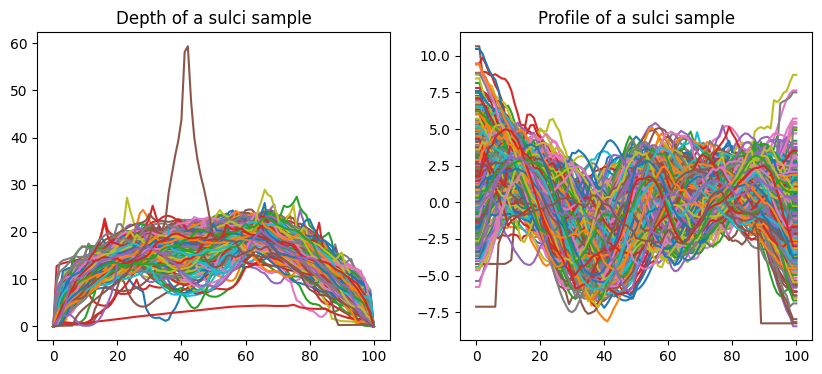

In [131]:
###############################
###############################
#   VISUALIZE
###############################
###############################


%matplotlib inline

view_low = 0 # min 0
view_high = 101 # max 101
sulci_idx_low = 0
sulci_idx_high = 436

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

""" Visualize depth """
for i in range(sulci_idx_low,sulci_idx_high):
    coord = data_param[i,view_low:view_high,0]
    depth = data_param[i,view_low:view_high,1]
    ax[0].plot(coord, depth)
ax[0].title.set_text("Depth of a sulci sample")

""" Visualize profile """
for i in range(sulci_idx_low,sulci_idx_high):
    coord = data_param[i,view_low:view_high,0]
    prof = data_param[i,view_low:view_high,2]
    ax[1].plot(coord, prof)
ax[1].title.set_text("Profile of a sulci sample")

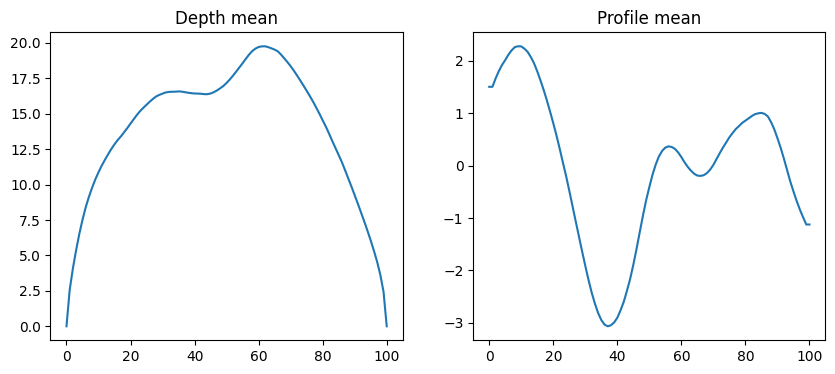

In [62]:
###############################
###############################
#   REMOVE OUTLIERS 
###############################
###############################


%matplotlib inline
# mean depth
depth_mean = np.mean(data_param[:,:,1], axis=0)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(coord, depth_mean)
ax[0].title.set_text("Depth mean")

# mean profile
prof_mean = np.mean(data_param[:,:,2], axis=0)

ax[1].plot(coord, prof_mean)
ax[1].title.set_text("Profile mean")

In [63]:
print("std: ", np.std(data_param[:,:,1]))
print("mean: ", np.mean(data_param[:,:,1]))
print("std i: ", np.std(data_param[143,:,1]))
print("mean i: ", np.mean(data_param[143,:,1]))

std:  5.392112237273136
mean:  13.91178286215944
std i:  6.7185841463711835
mean i:  8.90393064083224


In [132]:
outlier_std = []
for i in range(606):
    # FIRST BLOCK
    if  np.mean(data_param[i,:50,1]) <= (np.mean(data_param[:,:50,1]) -  np.std(data_param[:,:50,1])):
        outlier_std.append(i)
    elif  np.mean(data_param[i,:50,1]) > (np.mean(data_param[:,:50,1]) +  np.std(data_param[:,:50,1])):
        outlier_std.append(i)
    # SECOND BLOCK
    elif  np.mean(data_param[i,50:,1]) <= (np.mean(data_param[:, 50:,1]) - np.std(data_param[:,50:,1])):
        outlier_std.append(i)
    elif  np.mean(data_param[i,50:,1]) > (np.mean(data_param[:,50:,1]) + np.std(data_param[:,50:,1])):
        outlier_std.append(i)

print(outlier_std)

[10, 125, 142, 143, 273, 563]


In [133]:
idx_outlier_std_integrate = np.zeros((N_sulci,1))
idx_outlier_std_integrate[outlier_std] = 1
# extra
idx_outlier_std_integrate[435] = 1
idx_outlier_std_integrate = [int(x) for x in idx_outlier_std_integrate]

df["outlier_std"] = idx_outlier_std_integrate

/tmp/ipykernel_2464667/2695101447.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx_outlier_std_integrate = [int(x) for x in idx_outlier_std_integrate]


In [154]:
%matplotlib tk
matplotlib.rcParams.update({'font.size': 11})

view_low = 0 # min 0
view_high = 101 # max 101
sulci_idx_low = 20
sulci_idx_high = 40


fig, ax = plt.subplots()

""" Visualize depth """
for i in range(sulci_idx_low,sulci_idx_high):
    if (df.at[i, "outlier_std"] == 1 or df.at[i, 'outlier_diff_shape']==1):
        continue
    coord = data_param[i,view_low:view_high,0]
    depth = data_param[i,view_low:view_high,1]
    ax.plot(coord, depth, color = '#2F3EEA')
plt.title("Depth of a sulci sample")
plt.xlabel("Postion along the CS")
plt.show()

fig, ax = plt.subplots()
""" Visualize profile """
for i in range(sulci_idx_low,sulci_idx_high):
    if (df.at[i, "outlier_std"] == 1 or df.at[i, 'outlier_diff_shape']==1):
        continue
    coord = data_param[i,view_low:view_high,0]
    prof = data_param[i,view_low:view_high,2]#/(data_param[i,view_low:view_high,1]*2)
    ax.plot(coord, prof, color = '#2F3EEA')
plt.title("Profile of a sulci sample")
plt.xlabel("Postion along the CS")
plt.show()


In [135]:
df

,depth,profile,depth_peaks,depth_peaks_idx,prof_peaks,prof_peaks_idx,prof_valleys,prof_valleys_idx,outlier_diff_shape,outlier_std
0,"[0.0, 2.6798714803589974, 4.875863761408255, 5...","[0.528408920063692, 0.528408920063692, 0.93600...","[16.455385521054268, 21.19591757073067]","[32, 61]",[],[],[],[],0,0
1,"[0.0, 3.74437314691022, 5.314626330335159, 6.5...","[-1.3937141060829163, -1.3937141060829163, -1....","[12.906386589165775, 18.184166335035115, 20.60...","[14, 39, 60, 85]",[],[],[],[],0,0
2,"[0.0, 4.801219159155153, 7.062155766645446, 8....","[-0.23055722402489703, -0.23055722402489703, -...","[18.410773721989244, 21.95918939250987]","[24, 63]",[],[],[],[],0,0
3,"[0.0, 1.1962197124958038, 2.2727138635964366, ...","[3.441584146939791, 3.441584146939791, 3.73009...","[10.28246707600192, 18.57964706525672, 21.4073...","[11, 36, 65]",[],[],[],[],0,0
4,"[0.0, 4.664455382560845, 5.407005259767176, 6....","[1.9839385414123532, 1.9839385414123532, 1.939...","[17.681962803937495, 22.8378850009758, 16.5323...","[33, 56, 77]",[],[],[],[],0,0
...,...,...,...,...,...,...,...,...,...,...
601,"[0.0, 3.444729914830532, 4.798183510603849, 5....","[-2.2696852684021, -2.2696852684021, -1.605817...","[14.2673891489394, 20.283825988590248]","[29, 65]",[],[],[],[],0,0
602,"[0.0, 3.342899739567656, 4.441486263967818, 5....","[0.7796842522091336, 0.7796842522091336, 1.270...","[15.696904327021912, 18.79826330719516, 21.092...","[16, 39, 63]",[],[],[],[],0,0
603,"[0.0, 5.8978423536900655, 6.838870236009825, 8...","[1.145172913869222, 1.145172913869222, 1.72128...","[19.338180151273264, 19.647852451656945]","[33, 57]",[],[],[],[],0,0
604,"[0.0, 1.41141956258798, 3.140040917904116, 4.9...","[1.0428855969355657, 1.0428855969355657, 1.169...","[12.378713115816936, 19.901381589821536, 22.38...","[20, 43, 64, 87]",[],[],[],[],0,0


In [136]:
#save dataset

df.to_pickle("./output/complete_dataset/stats/data_bv_full_depth_prof.pkl")

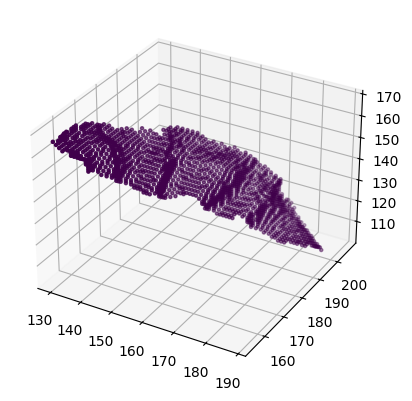

In [137]:
# visualize individual sulci

idx_cs = 1
%matplotlib inline


# Initialize figure and 3D axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

path_cs = path[idx_cs, 0] + '.nii.gz'
tmp = nib.load(path_cs)
cs = tmp.get_fdata()
indices = np.where(cs)
ax.scatter(indices[0], indices[1], indices[2], s=5, c=cs[indices], cmap='PRGn')
plt.show()

/tmp/ipykernel_2464667/63814886.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(medial_ax[:,0], medial_ax[:,1], medial_ax[:,2], s=5, cmap='PRGn')


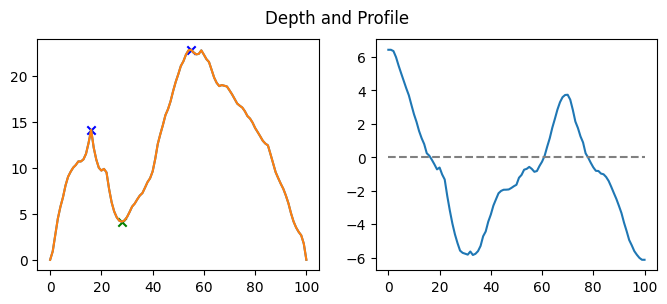

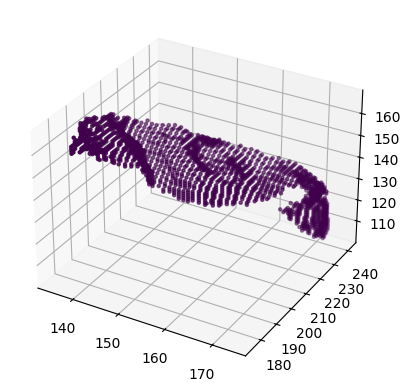

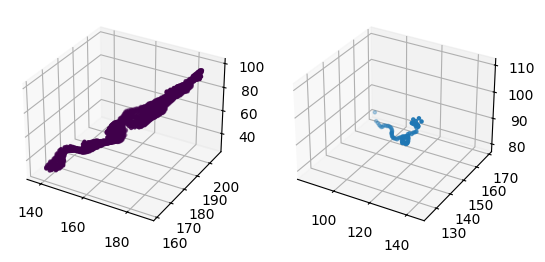

In [142]:
##################
# MEDIAL AXIS
#################

idx_cs=0

# See source_binary, only left
path_cs = path[idx_cs, 0] + '.nii.gz'
tmp = nib.load(path_cs)
cs = tmp.get_fdata()

%matplotlib inline
# Initialize figure and 3D axes
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')

indices = np.where(cs)
# Scatter plot with specified shifts
ax.scatter(indices[0], indices[1], indices[2], s=5, c=cs[indices], cmap='PRGn')

ax = fig.add_subplot(1, 2, 2, projection='3d')

medial_ax = data_medial_ax[idx_cs,:,:]

# Scatter plot with specified shifts
ax.scatter(medial_ax[:,0], medial_ax[:,1], medial_ax[:,2], s=5, cmap='PRGn') 

plt.show()